In [36]:
# Import packages

import pandas as pd 
import numpy as np 
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import plotly.express as px

import xgboost as xgb

from joblib import dump, load

pd.set_option('display.max_columns', None)

In [37]:
base = pd.read_csv('../data/adjusted_stats_over_under_modeling_base_df.csv')
model = load('../modeling/over_under_modeling/saved_models/ou_random_forest_av.joblib')
feature_list = ['passing_value_adjusted_home', 'rushing_value_adjusted_home', 'pass_def_value_adjusted_home', 'rush_def_value_adjusted_home', 'special_teams_value_home',
          'passing_value_adjusted_away', 'rushing_value_adjusted_away', 'pass_def_value_adjusted_away', 'rush_def_value_adjusted_away', 'special_teams_value_away',
          'total_possession_time_standardized_home', 'total_possession_time_standardized_away', 
          'total_plays_standardized_home', 'total_plays_standardized_away',
          'pass_percentage_standardized_home', 'pass_percentage_standardized_away']

In [38]:
# Get predictions and probabilites

base = base.dropna()
features = base[feature_list].to_numpy()

# Get win predictions/probabilities

win_preds = model.predict(features)
win_probs = model.predict_proba(features)

In [39]:
base['over_hits_pred'] = win_preds
base['over_hits_prob'] = win_probs[:,1]
base['under_hits_prob'] = win_probs[:,0]

In [40]:
base

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,total_possession_time_standardized_home,total_possession_time_standardized_away,total_plays_standardized_home,total_plays_standardized_away,pass_percentage_standardized_home,pass_percentage_standardized_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,over_hits,over_hits_pred,over_hits_prob,under_hits_prob
32,32,2014-09-21,2014,3,REG,New England Patriots,Las Vegas Raiders,16,9,Tom Brady,Derek Carr,0.387129,-0.120190,1.178166,0.163060,1.176841,-0.702046,0.774141,-0.954522,-0.448204,-0.351268,0.096176,-1.658769,0.459249,-1.223276,-0.621252,1.143133,New England Patriots,Las Vegas Raiders,16,9,25,-901.0,704.0,-14.0,14.0,47.5,under,-7,7,away,0.900100,0.124378,home,11.10,-100.0,11.10,-100.0,-100.00,90.91,-100.00,90.91,-100.00,90.91,0,0,0.077567,0.922433
35,35,2014-09-21,2014,3,REG,Cleveland Browns,Baltimore Ravens,21,23,Brian Hoyer,Joe Flacco,-0.137203,0.141640,0.192438,-0.869159,-0.162922,0.388264,0.048372,0.786102,-0.208942,0.137405,-0.538465,0.569921,0.548983,1.154692,-0.359257,-0.103556,Cleveland Browns,Baltimore Ravens,21,23,44,111.0,-123.0,2.0,-2.0,43.0,over,2,-2,push,0.473934,0.551570,away,81.30,-100.0,-100.00,81.3,0.00,0.00,0.00,0.00,90.91,-100.00,1,1,0.715733,0.284267
36,36,2014-09-21,2014,3,REG,Carolina Panthers,Pittsburgh Steelers,19,37,Cam Newton,Ben Roethlisberger,0.604152,-0.878958,0.309284,0.344995,1.301579,-0.782914,0.355480,-0.482694,-0.196212,0.017013,-0.226359,-0.542934,-0.101593,-0.281062,0.373782,0.376088,Carolina Panthers,Pittsburgh Steelers,19,37,56,-190.0,171.0,-3.0,3.0,42.5,over,18,-18,away,0.655172,0.369004,away,-100.00,171.0,-100.00,171.0,-100.00,90.91,-100.00,90.91,90.91,-100.00,1,1,0.688781,0.311219
37,37,2014-09-21,2014,3,REG,Arizona Cardinals,San Francisco 49ers,23,14,Drew Stanton,Colin Kaepernick,-0.857878,0.359969,-0.160789,0.607663,1.173452,-0.287031,-0.471071,-0.239934,0.452426,0.402579,-0.628596,0.317406,-0.101593,-0.415664,-0.373010,-0.511114,Arizona Cardinals,San Francisco 49ers,23,14,37,136.0,-150.0,3.0,-3.0,41.0,under,-9,9,home,0.423729,0.600000,home,-100.00,136.0,136.00,-100.0,-100.00,90.91,90.91,-100.00,-100.00,90.91,0,0,0.385572,0.614428
38,38,2014-09-21,2014,3,REG,Buffalo Bills,Los Angeles Chargers,10,22,EJ Manuel,Philip Rivers,0.531544,-0.912222,0.256764,0.606452,1.562575,0.804905,-0.212663,-0.100618,-0.538650,1.051236,-0.198053,1.406425,-0.370797,0.593851,-1.418698,-0.429705,Buffalo Bills,Los Angeles Chargers,10,22,32,-130.0,118.0,-2.5,2.5,45.5,under,12,-12,away,0.565217,0.458716,away,-100.00,118.0,-100.00,118.0,-100.00,90.91,-100.00,90.91,-100.00,90.91,0,0,0.487468,0.512532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,2401,2023-01-21,2022,20,POST,Philadelphia Eagles,New York Giants,38,7,Jalen Hurts,Daniel Jones,-0.064103,1.383454,0.238265,-0.015817,0.227185,0.511665,1.405749,0.193354,-0.495465,-0.305645,0.291335,0.428766,0.784537,0.234912,-0.330543,-0.315440,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,-100.0,26.32,-100.0,90.91,-100.00,90.91,-100.00,-100.00,90.91,0,1,0.560764,0.4

In [41]:
# Set what part of the data to analyze
# Most models will just look at the test set (2022 for now)
# For models with very low overfitting, could be fruitful to look at the results on the entire data set though

# analysis_df = base[base.season != 2022]
analysis_df = base[base.season == 2022]
analysis_df['pred_correct'] = analysis_df.apply(lambda x: 1 if x.over_hits == x.over_hits_pred else 0, axis=1)
analysis_df.head()

/tmp/ipykernel_1233962/626107209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['pred_correct'] = analysis_df.apply(lambda x: 1 if x.over_hits == x.over_hits_pred else 0, axis=1)


,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,total_possession_time_standardized_home,total_possession_time_standardized_away,total_plays_standardized_home,total_plays_standardized_away,pass_percentage_standardized_home,pass_percentage_standardized_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,over_hits,over_hits_pred,over_hits_prob,under_hits_prob,pred_correct
2097,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,0.722622,0.394501,0.520941,0.038617,-0.030552,-0.319587,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,0,0.489480,0.510520,1
2098,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,0.526532,-0.259879,0.156394,-0.303496,-0.871415,-0.052171,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,0,0,0.493794,0.506206,1
2101,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,-0.987443,1.468809,-0.841904,1.188342,0.407590,-0.075841,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1,0.552995,0.447005,0
2104,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,-0.485020,-0.016116,-0.224978,-0.135243,-0.236068,-0.331271,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0,0.456923,0.543077,0
2105,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,-0.276266,0.026901,0.201262,-0.393230,-0.219241,-1.353506,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,0,0,0.214520,0.785480,1


In [42]:
# Get general accuracy measurements

accuracy = accuracy_score(analysis_df.over_hits, analysis_df.over_hits_pred)
tn, fp, fn, tp = confusion_matrix(analysis_df.over_hits, analysis_df.over_hits_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print()
print('True Positive Rate: {}'.format(tp/(tp+fn)))
print('False Positive Rate: {}'.format(fp/(fp+tn)))
print('True Negative Rate: {}'.format(tn/(tn+fp)))
print('False Negative Rate: {}'.format(fn/(fn+tp)))

Accuracy: 0.4875
Precision: 0.4444444444444444
Recall: 0.4727272727272727

True Positive Rate: 0.4727272727272727
False Positive Rate: 0.5
True Negative Rate: 0.5
False Negative Rate: 0.5272727272727272


<Axes: >

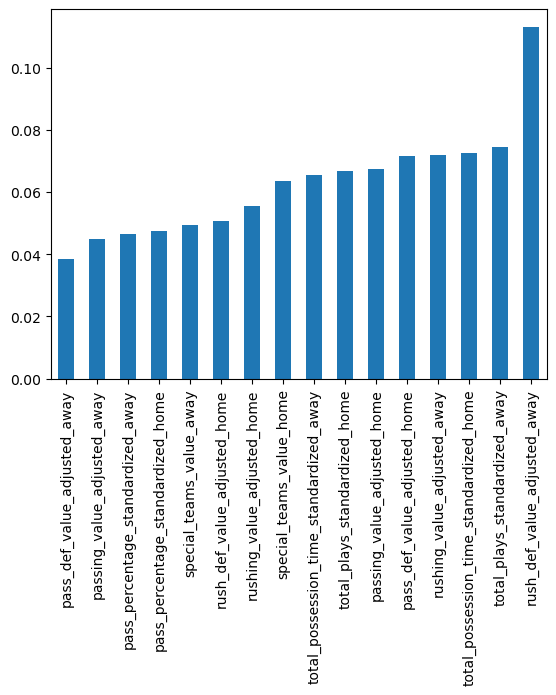

In [43]:
# Feature Importance

importances = pd.Series(model.feature_importances_, index = feature_list).sort_values()
importances.plot.bar()

In [45]:
# Get NFL translated accuracy stats

over_hits_pct = sum(analysis_df.over_hits==1)/len(analysis_df)
under_hits_pct = sum(analysis_df.over_hits==0)/len(analysis_df)

over_hits_pred_pct = sum(analysis_df.over_hits_pred==1)/len(analysis_df)
under_hits_pred_pct = sum(analysis_df.over_hits_pred==0)/len(analysis_df)

print('Over Hits Percentage: {}'.format(over_hits_pct))
print('Under Hits Percentage: {}'.format(under_hits_pct))
print('Over Hits Predicted Percentage: {}'.format(over_hits_pred_pct))
print('Under Hits Predicted Percentage: {}'.format(under_hits_pred_pct))

Over Hits Percentage: 0.4583333333333333
Under Hits Percentage: 0.5416666666666666
Over Hits Predicted Percentage: 0.4875
Under Hits Predicted Percentage: 0.5125


In [46]:
overs = analysis_df[analysis_df.over_hits==1]
unders = analysis_df[analysis_df.over_hits==0]

overs_acc = accuracy_score(overs.over_hits, overs.over_hits_pred)
unders_acc = accuracy_score(unders.over_hits, unders.over_hits_pred)

overs_pred = analysis_df[analysis_df.over_hits_pred==1]
unders_pred = analysis_df[analysis_df.over_hits_pred==0]

overs_pred_acc = accuracy_score(overs_pred.over_hits, overs_pred.over_hits_pred)
unders_pred_acc = accuracy_score(unders_pred.over_hits, unders_pred.over_hits_pred)

print('Accuracy for Over Hits: {}'.format(overs_acc))
print('Accuracy for Under Hits: {}'.format(unders_acc))
print()
print('Accuracy for Over Predicted: {}'.format(overs_pred_acc))
print('Accuracy for Unders Predicted: {}'.format(unders_pred_acc))

Accuracy for Over Hits: 0.4727272727272727
Accuracy for Under Hits: 0.5

Accuracy for Over Predicted: 0.4444444444444444
Accuracy for Unders Predicted: 0.5284552845528455


<Axes: xlabel='over_hits_prob', ylabel='over_hits'>

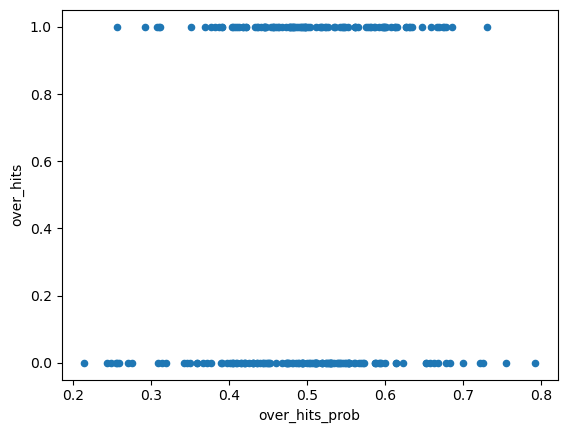

In [47]:
# Plot home win probability vs result

analysis_df.plot.scatter(x='over_hits_prob', y='over_hits')

      correct_preds  total_games  accuracy
week                                      
1                 4           10  0.400000
2                 6           14  0.428571
3                11           16  0.687500
4                 3           12  0.250000
5                 9           15  0.600000
6                 9           13  0.692308
7                 6           13  0.461538
8                 1           12  0.083333
9                 6           11  0.545455
10                8           14  0.571429
11                9           14  0.642857
12                4           13  0.307692
13                7           12  0.583333
14                5           10  0.500000
15                8           15  0.533333
16                5           14  0.357143
17                3            9  0.333333
18                7           11  0.636364
19                3            6  0.500000
20                1            4  0.250000
21                1            1  1.000000
22         

<Axes: xlabel='week'>

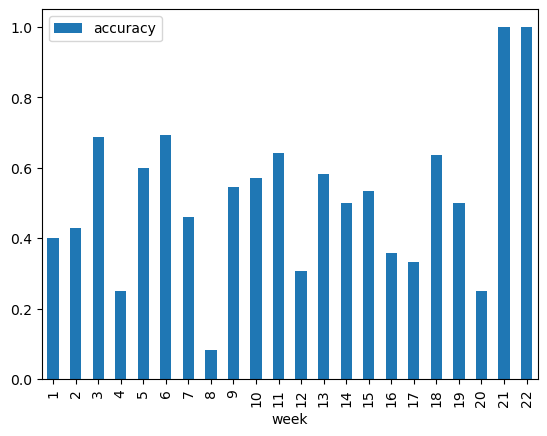

In [48]:
# Week by week accuracy

weekly = analysis_df.groupby(by='week').agg(correct_preds=('pred_correct', 'sum'), total_games=('pred_correct', 'count'))
weekly['accuracy'] = weekly.correct_preds/weekly.total_games
print(weekly)
weekly.plot.bar(y='accuracy')

In [49]:
# Average Confidence
# When correctly predicting a win, how confident were we in the prediction on average?
# Likewise, when incorrect, how confident were we?

pred_confs = analysis_df[['pred_correct', 'over_hits', 'over_hits_prob', 'under_hits_prob']].groupby(by=['pred_correct', 'over_hits']).mean()[['over_hits_prob', 'under_hits_prob']]
pred_confs

over_hits_prob  under_hits_prob
pred_correct over_hits                                 
0            0                0.574465         0.425535
             1                0.435454         0.564546
1            0                0.406476         0.593524
             1                0.588800         0.411200

In [50]:
game_with_lines = analysis_df.copy()
game_with_lines.head()

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,total_possession_time_standardized_home,total_possession_time_standardized_away,total_plays_standardized_home,total_plays_standardized_away,pass_percentage_standardized_home,pass_percentage_standardized_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,over_hits,over_hits_pred,over_hits_prob,under_hits_prob,pred_correct
2097,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,0.722622,0.394501,0.520941,0.038617,-0.030552,-0.319587,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,0,0.489480,0.510520,1
2098,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,0.526532,-0.259879,0.156394,-0.303496,-0.871415,-0.052171,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,0,0,0.493794,0.506206,1
2101,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,-0.987443,1.468809,-0.841904,1.188342,0.407590,-0.075841,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1,0.552995,0.447005,0
2104,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,-0.485020,-0.016116,-0.224978,-0.135243,-0.236068,-0.331271,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0,0.456923,0.543077,0
2105,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,-0.276266,0.026901,0.201262,-0.393230,-0.219241,-1.353506,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,0,0,0.214520,0.785480,1


In [51]:
game_with_lines['over_advantage'] = game_with_lines.apply(lambda x: x.over_hits_prob-.5, axis=1)
game_with_lines['under_advantage'] = game_with_lines.apply(lambda x: x.under_hits_prob-.5, axis=1)
game_with_lines.head()

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,total_possession_time_standardized_home,total_possession_time_standardized_away,total_plays_standardized_home,total_plays_standardized_away,pass_percentage_standardized_home,pass_percentage_standardized_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,over_hits,over_hits_pred,over_hits_prob,under_hits_prob,pred_correct,over_advantage,under_advantage
2097,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,0.722622,0.394501,0.520941,0.038617,-0.030552,-0.319587,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,0,0.489480,0.510520,1,-0.010520,0.010520
2098,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,0.526532,-0.259879,0.156394,-0.303496,-0.871415,-0.052171,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,0,0,0.493794,0.506206,1,-0.006206,0.006206
2101,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,-0.987443,1.468809,-0.841904,1.188342,0.407590,-0.075841,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1,0.552995,0.447005,0,0.052995,-0.052995
2104,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,-0.485020,-0.016116,-0.224978,-0.135243,-0.236068,-0.331271,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0,0.456923,0.543077,0,-0.043077,0.043077
2105,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,-0.276266,0.026901,0.201262,-0.393230,-0.219241,-1.353506,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,0,0,0.214520,0.785480,1,-0.285480,0.285480


In [99]:
# How does accuracy change when the confidence thresholds are adjusted?

thresholds = [0, .01, .02, .03, .05, .06, .07, .085, .1, .125, .15, .2]
accuracies = []
num_games_bet = []

for threshold in thresholds:
    threshold_df = game_with_lines[np.abs(game_with_lines.over_advantage) >= threshold]
    accuracy = accuracy_score(threshold_df.over_hits, threshold_df.over_hits_pred)
    
    accuracies.append(accuracy)
    num_games_bet.append(len(threshold_df))

In [100]:
accuracies

[0.4875,
 0.4977168949771689,
 0.5128205128205128,
 0.5227272727272727,
 0.5625,
 0.5905511811023622,
 0.5909090909090909,
 0.5851063829787234,
 0.6,
 0.6274509803921569,
 0.5526315789473685,
 0.6]

In [101]:
num_games_bet

[240, 219, 195, 176, 144, 127, 110, 94, 70, 51, 38, 15]

In [102]:
def get_algo_returns(game, threshold):
    if game.over_advantage > game.under_advantage:
        bet_team = 'over'
        bet_advantage = game.over_advantage
    else:
        bet_team = 'under'
        bet_advantage = game.under_advantage
        
    if bet_advantage < threshold:
        return 0 
    
    else:
        return game['{}_return'.format(bet_team)]
    
    
threshold_var=0.07
threshold = threshold_var

game_with_lines['algo_return'] = game_with_lines.apply(lambda x: get_algo_returns(x, threshold), axis=1)

In [103]:
game_with_lines

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,total_possession_time_standardized_home,total_possession_time_standardized_away,total_plays_standardized_home,total_plays_standardized_away,pass_percentage_standardized_home,pass_percentage_standardized_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,over_hits,over_hits_pred,over_hits_prob,under_hits_prob,pred_correct,over_advantage,under_advantage,algo_return
2097,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,0.722622,0.394501,0.520941,0.038617,-0.030552,-0.319587,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,0,0.489480,0.510520,1,-0.010520,0.010520,0.00
2098,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,0.526532,-0.259879,0.156394,-0.303496,-0.871415,-0.052171,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,0,0,0.493794,0.506206,1,-0.006206,0.006206,0.00
2101,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,-0.987443,1.468809,-0.841904,1.188342,0.407590,-0.075841,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1,0.552995,0.447005,0,0.052995,-0.052995,0.00
2104,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,-0.485020,-0.016116,-0.224978,-0.135243,-0.236068,-0.331271,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0,0.456923,0.543077,0,-0.043077,0.043077,0.00
2105,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,-0.276266,0.026901,0.201262,-0.393230,-0.219241,-1.353506,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,0,0,0.214520,0.785480,1,-0.285480,0.285480,90.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,2401,2023-01-21,2022,20,POST,Philadelphia Eagles,New York Giants,38,7,Jalen Hurts,Daniel Jones,-0.064103,1.383454,0.238265,-0.015817,0.227185,0.511665,1.405749,0.193354,-0.495465,-0.305645,0.291335,0.428766,0.784537,0.234912,-0.330543,-0.315440,P

In [104]:
# Test Season total return

# test_with_lines = game_with_lines[game_with_lines.season != 2022]
test_with_lines = game_with_lines[game_with_lines.season == 2022]

sum(test_with_lines.algo_return)

1409.150000000001

/tmp/ipykernel_1233962/1829231814.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



<Axes: xlabel='week'>

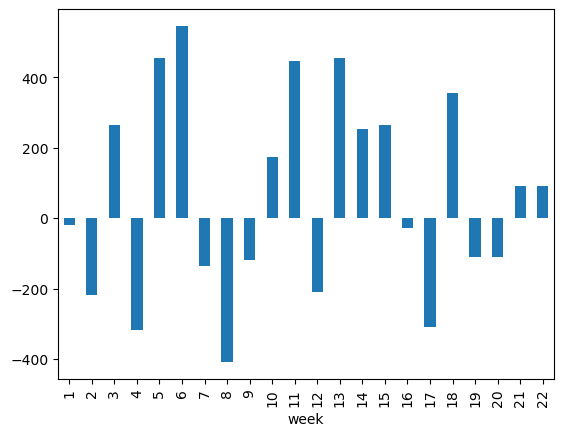

In [105]:
# Week by week return 
test_with_lines.groupby(by='week').sum()['algo_return'].plot.bar()

/tmp/ipykernel_1233962/1502147613.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



<Axes: xlabel='season'>

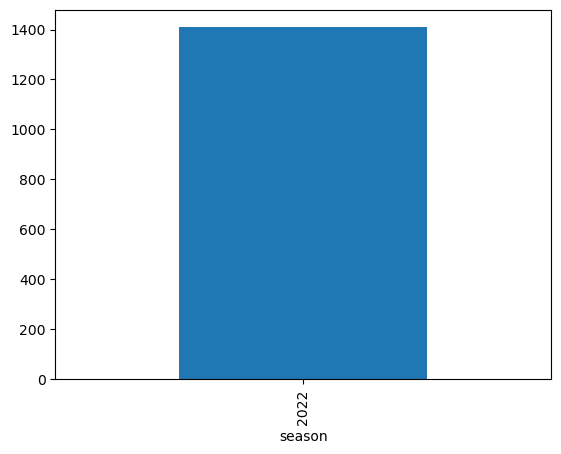

In [106]:
# Season by season return 
test_with_lines.groupby(by='season').sum()['algo_return'].plot.bar()

In [107]:
test_with_lines[test_with_lines.week == 9]

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,total_possession_time_standardized_home,total_possession_time_standardized_away,total_plays_standardized_home,total_plays_standardized_away,pass_percentage_standardized_home,pass_percentage_standardized_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,over_hits,over_hits_pred,over_hits_prob,under_hits_prob,pred_correct,over_advantage,under_advantage,algo_return
2218,2247,2022-11-03,2022,9,REG,Houston Texans,Philadelphia Eagles,17,29,Davis Mills,Jalen Hurts,-0.326857,0.601305,-0.317272,-0.673932,0.135103,0.490893,0.823709,0.692349,-0.812650,0.359468,-0.178128,0.347015,-0.522224,-0.011858,0.185882,-0.621678,Houston Texans,Philadelphia Eagles,17,29,46,550.0,-833.0,14.0,-14.0,45.5,over,12,-12,home,0.153846,0.892819,away,12.00,-100.0,-100.00,12.00,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0,0.390926,0.609074,0,-0.109074,0.109074,-100.00
2219,2248,2022-11-06,2022,9,REG,Chicago Bears,Miami Dolphins,32,35,Justin Fields,Tua Tagovailoa,-0.658059,1.066110,-0.144549,-0.933052,0.475565,1.052800,0.037077,-0.125609,-0.401633,-0.376366,0.663218,-0.201033,0.257346,-0.628784,-1.549414,0.257672,Chicago Bears,Miami Dolphins,32,35,67,165.0,-185.0,4.0,-4.0,46.0,over,3,-3,home,0.377358,0.649123,away,54.05,-100.0,-100.00,54.05,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0,0.460288,0.539712,0,-0.039712,0.039712,0.00
2220,2249,2022-11-06,2022,9,REG,Washington Football Team,Minnesota Vikings,17,20,Taylor Heinicke,Kirk Cousins,-0.450986,0.082502,0.386707,-0.184862,0.084887,-0.140009,0.399190,0.049527,0.425651,-0.072509,0.480722,-0.093211,0.027401,0.049834,-0.750867,0.281040,Washington Football Team,Minnesota Vikings,17,20,37,145.0,-167.0,3.0,-3.0,43.5,under,3,-3,push,0.408163,0.625468,away,59.88,-100.0,-100.00,59.88,0.00,0.00,0.00,0.00,-100.00,90.91,0,0,0.493960,0.506040,1,-0.006040,0.006040,0.00
2221,2250,2022-11-06,2022,9,REG,New York Jets,Buffalo Bills,20,17,Zach Wilson,Josh Allen,-0.500462,0.168845,0.676616,0.293947,-0.155008,0.504940,0.904304,0.221205,-0.346954,0.756668,-0.553363,-0.717609,-0.757777,-0.281062,-0.161741,0.056793,New York Jets,Buffalo Bills,20,17,37,425.0,-556.0,10.5,-10.5,46.0,under,-3,3,home,0.190476,0.847561,home,-100.00,425.0,425.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,0,0,0.436022,0.563978,1,-0.063978,0.063978,0.00
2222,2251,2022-11-06,2022,9,REG,New England Patriots,Indianapolis Colts,26,3,Mac Jones,Sam Ehlinger,-0.321911,0.343414,0.354209,0.383689,0.745840,0.105051,-1.104190,-0.082563,0.243010,0.178876,0.389473,-0.222634,0.352689,-0.998939,-0.137337,-1.112900,New England Patriots,Indianapolis Colts,26,3,29,-233.0,190.0,-5.0,5.0,40.0,under,-23,23,home,0.699700,0.344828,home,42.92,-100.0,42.92,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,0,0,0.255242,0.744758,1,-0.244758,0.244758,90.91
2223,2252,2022-11-06,2022,9,REG,Detroit Lions,Green Bay Packers,15,9,Jared Goff,Aaron Rodgers,-0.290674,-0.195708,-1.071432,-0.516376,0.105475,-0.301369,0.071969,-0.079011,-0.564353,-0.686464,-0.471053,-0.010343,-0.443706,-0.320321,0.179771,0.390119,Detroit Lions,Green Bay Packers,15,9,24,167.0,-192.0,4.0,-4.0,49.5,under,-6,6,home,0.374532,0.657534,home,-100.00,167.0,167.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,0,0,0.408756,0.591244,1,-0.091244,0.091244,90.91
2224,2253,2022

In [108]:
# Should move these to helper functions later

def get_algo_returns_over(game, threshold):
    if game.over_advantage < threshold:
        return 0 
    
    else:
        return game.over_return
    
def get_algo_returns_under(game, threshold):
    if game.under_advantage < threshold:
        return 0 
    
    else:
        return game.under_return
    
threshold = threshold_var

test_with_lines['algo_return_overs'] = test_with_lines.apply(lambda x: get_algo_returns_over(x, threshold), axis=1)
test_with_lines['algo_return_unders'] = test_with_lines.apply(lambda x: get_algo_returns_under(x, threshold), axis=1)
test_with_lines

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,total_possession_time_standardized_home,total_possession_time_standardized_away,total_plays_standardized_home,total_plays_standardized_away,pass_percentage_standardized_home,pass_percentage_standardized_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,over_hits,over_hits_pred,over_hits_prob,under_hits_prob,pred_correct,over_advantage,under_advantage,algo_return,algo_return_overs,algo_return_unders
2097,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,0.722622,0.394501,0.520941,0.038617,-0.030552,-0.319587,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,0,0.489480,0.510520,1,-0.010520,0.010520,0.00,0.00,0.00
2098,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,0.526532,-0.259879,0.156394,-0.303496,-0.871415,-0.052171,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,0,0,0.493794,0.506206,1,-0.006206,0.006206,0.00,0.00,0.00
2101,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,-0.987443,1.468809,-0.841904,1.188342,0.407590,-0.075841,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1,0.552995,0.447005,0,0.052995,-0.052995,0.00,0.00,0.00
2104,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,-0.485020,-0.016116,-0.224978,-0.135243,-0.236068,-0.331271,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0,0.456923,0.543077,0,-0.043077,0.043077,0.00,0.00,0.00
2105,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,-0.276266,0.026901,0.201262,-0.393230,-0.219241,-1.353506,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,0,0,0.214520,0.785480,1,-0.285480,0.285480,90.91,0.00,90.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,2401,2023-01-21,2022,20,POST,Philadelphia Eagles,New York Giants,38,7,Jalen Hurts,Daniel Jones,-0.064103,1.383454,0.238265,-0.015817,0.227185,0.511665

In [109]:
# Look at outcomes by home, away, favorite, underdog, etc.

test_pivoted = test_with_lines.copy().reset_index()
test_pivoted = test_pivoted.groupby(by='week').sum().reset_index()
test_pivoted = pd.melt(test_pivoted, id_vars = ['week'],
              value_vars=['algo_return_overs', 'algo_return_unders'],
             var_name='algo_return_type', value_name='return')
test_pivoted

/tmp/ipykernel_1233962/35314960.py:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,week,algo_return_type,return
0,1,algo_return_overs,-100.00
1,2,algo_return_overs,-118.18
2,3,algo_return_overs,181.82
3,4,algo_return_overs,-209.09
4,5,algo_return_overs,90.91
5,6,algo_return_overs,181.82
6,7,algo_return_overs,-100.00
7,8,algo_return_overs,-109.09
8,9,algo_return_overs,-100.00
9,10,algo_return_overs,81.82


<Axes: >

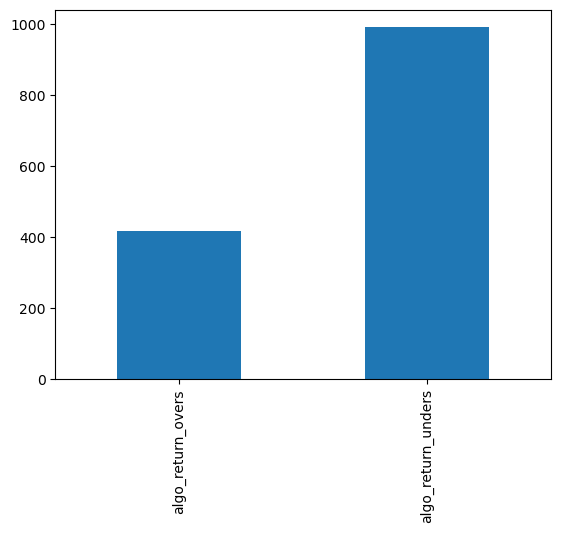

In [110]:
test_with_lines.sum()[['algo_return_overs', 'algo_return_unders']].plot.bar()

In [111]:
# Week by week return 

fig = px.bar(test_pivoted, x="week", y="return", color='algo_return_type')
fig.show()

In [112]:
# Get accuracies 

def get_algo_acc(game, column):
    if game[column] > 0:
        return 1
    elif game[column] < 0:
        return 0 
    else:
        return None

test_with_lines['algo_overs_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_overs'), axis=1)
test_with_lines['algo_unders_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_unders'), axis=1)
test_with_lines

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,total_possession_time_standardized_home,total_possession_time_standardized_away,total_plays_standardized_home,total_plays_standardized_away,pass_percentage_standardized_home,pass_percentage_standardized_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,over_hits,over_hits_pred,over_hits_prob,under_hits_prob,pred_correct,over_advantage,under_advantage,algo_return,algo_return_overs,algo_return_unders,algo_overs_acc,algo_unders_acc
2097,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,0.722622,0.394501,0.520941,0.038617,-0.030552,-0.319587,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,0,0.489480,0.510520,1,-0.010520,0.010520,0.00,0.00,0.00,NaN,NaN
2098,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,0.526532,-0.259879,0.156394,-0.303496,-0.871415,-0.052171,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,0,0,0.493794,0.506206,1,-0.006206,0.006206,0.00,0.00,0.00,NaN,NaN
2101,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,-0.987443,1.468809,-0.841904,1.188342,0.407590,-0.075841,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1,0.552995,0.447005,0,0.052995,-0.052995,0.00,0.00,0.00,NaN,NaN
2104,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,-0.485020,-0.016116,-0.224978,-0.135243,-0.236068,-0.331271,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0,0.456923,0.543077,0,-0.043077,0.043077,0.00,0.00,0.00,NaN,NaN
2105,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,-0.276266,0.026901,0.201262,-0.393230,-0.219241,-1.353506,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,0,0,0.214520,0.785480,1,-0.285480,0.285480,90.91,0.00,90.91,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,2401,2023-01-21,2022,20,POST,Philadelphia Eagles,New York Giants,38,7,J

In [113]:
accs = test_with_lines.groupby(by='week').agg(
    algo_over_correct = ('algo_overs_acc', 'sum'),
    algo_over_total = ('algo_overs_acc', 'count'),
    algo_under_correct = ('algo_unders_acc', 'sum'),
    algo_under_total = ('algo_unders_acc', 'count'),
)

accs['algo_overs_acc'] = accs.algo_over_correct/accs.algo_over_total
accs['algo_away_acc'] = accs.algo_under_correct/accs.algo_under_total

<Axes: xlabel='week'>

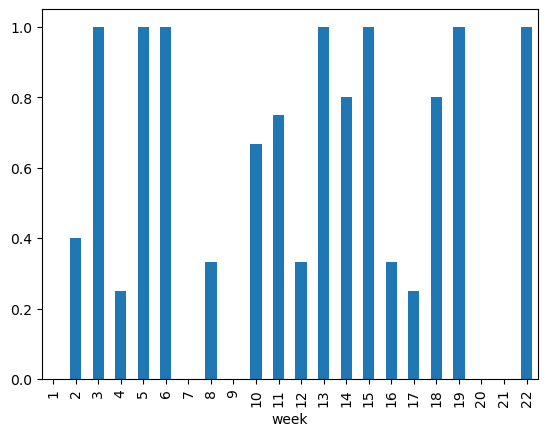

In [114]:
check_col = 'algo_overs_acc'
accs[check_col].plot.bar()

<Axes: >

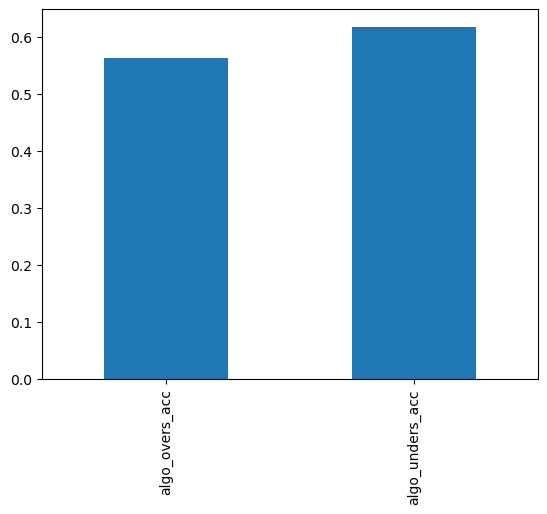

In [115]:
accs2 = test_with_lines.agg(['sum','count']).transpose().loc[['algo_overs_acc', 'algo_unders_acc']]
accs2['accuracy'] = accs2['sum']/accs2['count']
accs2.accuracy.plot.bar()

In [116]:
# Total bet counts

len(test_with_lines[test_with_lines.algo_return != 0])

110

In [117]:
test_with_lines[test_with_lines.algo_return!=0][['date', 'week', 'home_team', 'away_team', 'home_score_x', 'away_score_x', 'algo_return', 'over_advantage', 'under_advantage']]

,date,week,home_team,away_team,home_score_x,away_score_x,algo_return,over_advantage,under_advantage
2105,2022-09-11,1,Chicago Bears,San Francisco 49ers,19,10,90.91,-0.285480,0.285480
2107,2022-09-11,1,Minnesota Vikings,Green Bay Packers,23,7,-100.00,0.087234,-0.087234
2108,2022-09-11,1,Arizona Cardinals,Kansas City Chiefs,21,44,-100.00,-0.117134,0.117134
2110,2022-09-11,1,Los Angeles Chargers,Las Vegas Raiders,24,19,90.91,-0.229384,0.229384
2113,2022-09-15,2,Kansas City Chiefs,Los Angeles Chargers,27,24,-100.00,0.225256,-0.225256
...,...,...,...,...,...,...,...,...,...
2370,2023-01-21,20,Kansas City Chiefs,Jacksonville Jaguars,27,20,90.91,-0.097971,0.097971
2372,2023-01-22,20,Buffalo Bills,Cincinnati Bengals,10,27,-100.00,0.199933,-0.199933
2373,2023-01-22,20,San Francisco 49ers,Dallas Cowboys,19,12,-100.00,0.168139,-0.168139
2375,2023-01-29,21,Kansas City Chiefs,Cincinnati Bengals,23,20,90.91,-0.140828,0.140828


<Axes: >

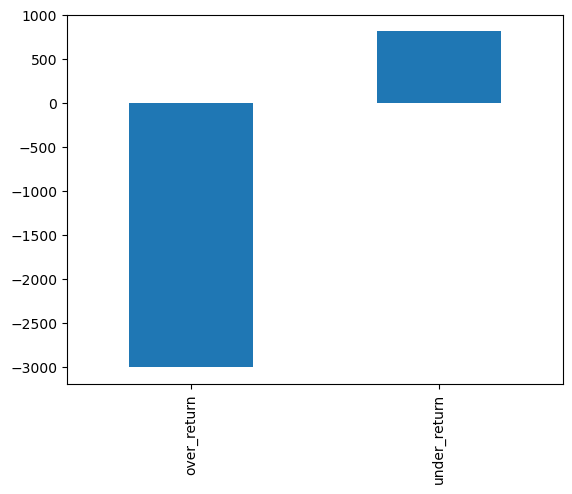

In [118]:
test_with_lines[['over_return', 'under_return']].sum().plot.bar()

In [119]:
# NOTE

do some eda, maybe 6 games isnt the best number
maybe would be good to use previous season data for the early weeks as well
can look at autocorrelation? see how the correlation between stats changes the farther the number of games is
may find that after 4 or 5 games the correlation gets very small, or maybe the opposite

SyntaxError: invalid syntax (206508906.py, line 3)